<a href="https://colab.research.google.com/github/Jaeji/AM360Paper/blob/main/Model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: ติดตั้งระบบและ Clone ไฟล์ (Hacker Style)

In [2]:
# =========================================================
# 📦 SECTION 1: SETUP & GIT CLONE (Python 3.12 Compatible)
# =========================================================
import os
import shutil
import requests
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ตั้งค่ากราฟสวยๆ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("🚀 Initiating System Setup & Cloning...")

# 1. ตั้งค่า Git Repo
repo_url = "https://github.com/Jaeji/AM360Paper.git"
repo_name = "AM360Paper"

# 2. เคลียร์พื้นที่เก่า
if os.path.exists(repo_name): shutil.rmtree(repo_name)
if os.path.exists("B0005.mat"): os.remove("B0005.mat")

# 3. สั่ง Clone
print(f"📡 Cloning Repository: {repo_url}...")
!git clone {repo_url}

# 4. ย้ายไฟล์
source_path = f"{repo_name}/B0005.mat"
destination = "B0005.mat"

if os.path.exists(source_path):
    shutil.move(source_path, destination)
    shutil.rmtree(repo_name)
    print(f"✅ Mission Complete: ได้ไฟล์ {destination} มาแล้ว!")
else:
    print(f"❌ Error: ไม่พบไฟล์ (เช็คชื่อไฟล์ใน Git อีกทีนะครับ)")

🚀 Initiating System Setup & Cloning...
📡 Cloning Repository: https://github.com/Jaeji/AM360Paper.git...
Cloning into 'AM360Paper'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 15.22 MiB | 46.39 MiB/s, done.
Resolving deltas: 100% (3/3), done.
✅ Mission Complete: ได้ไฟล์ B0005.mat มาแล้ว!


# Section 2: แปลงข้อมูล (Data Preparation)

In [4]:
def load_and_prep_data(filepath='B0005.mat'):
    print(f"🛠️ กำลังแปลงข้อมูลจาก {filepath} ...")

    if not os.path.exists(filepath):
        print("❌ ไม่พบไฟล์! กรุณารัน Section 1 ใหม่อีกรอบครับ")
        return None

    mat = scipy.io.loadmat(filepath)
    data = mat['B0005'][0][0][0][0]

    dataset = []
    last_charge = {'time_at_4_15v': 0, 'min_voltage': 0}

    for i, cycle in enumerate(data):
        c_type = cycle['type'][0]
        if c_type == 'charge':
            try:
                d = cycle['data'][0][0]
                t = d['Time'][0]; v = d['Voltage_measured'][0]
                high_v = np.where(v >= 4.15)[0]
                t_415 = t[high_v[-1]] - t[high_v[0]] if len(high_v) > 1 else 0
                last_charge = {'time_at_4_15v': t_415, 'min_voltage': np.min(v)}
            except: pass
        elif c_type == 'discharge':
            try:
                d = cycle['data'][0][0]
                t = d['Time'][0]; v = d['Voltage_measured'][0]
                dataset.append({
                    'discharge_time': t[-1] - t[0],
                    'max_voltage': np.max(v),
                    'min_voltage_charge': last_charge['min_voltage'],
                    'time_at_4_15v': last_charge['time_at_4_15v'],
                    'Capacity': d['Capacity'][0][0]
                })
            except: pass

    df = pd.DataFrame(dataset)

    # สร้าง Target RUL
    eol_idx = df[df['Capacity'] < 1.4].index
    eol = eol_idx[0] if len(eol_idx) > 0 else len(df)

    # --- แก้ไขจุดที่ Error (แยกบรรทัด) ---
    df['RUL'] = eol - df.index        # คำนวณค่าก่อน (จะได้เป็น Series ในตาราง)
    df['RUL'] = df['RUL'].clip(lower=0) # แล้วค่อยสั่ง clip ทีหลัง (Series มี .clip เสมอ)
    # ---------------------------------

    print(f"✅ ข้อมูลพร้อมใช้งาน: {len(df)} แถว")
    return df

df = load_and_prep_data()

🛠️ กำลังแปลงข้อมูลจาก B0005.mat ...
✅ ข้อมูลพร้อมใช้งาน: 168 แถว


# Section 3: ประลองโมเดล (AutoML Comparison)

In [5]:
# เตรียมข้อมูลสอบ
features = ['discharge_time', 'max_voltage', 'min_voltage_charge', 'time_at_4_15v']
X = df[features]
y = df['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# รายชื่อนักสู้ (Models) ที่จะเอามาแข่งกัน
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest    ": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost (Hero)   ": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
}

print("🥊 เริ่มการประลองโมเดล (Model Comparison)...")
print("="*60)
print(f"{'Model Name':<20} | {'RMSE (ยิ่งน้อยยิ่งดี)':<20} | {'R2 Score (ยิ่งมากยิ่งดี)':<20}")
print("-" * 60)

results = {}

for name, model in models.items():
    # เทรนโมเดล
    model.fit(X_train, y_train)

    # สอบ
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    # เก็บผล
    results[name] = model
    print(f"{name:<20} | {rmse:<20.4f} | {r2:<20.4f}")

print("="*60)
print("✅ การประลองเสร็จสิ้น! เลือกใช้ XGBoost สำหรับ Section ถัดไป")

# เลือก XGBoost มาใช้งานจริง
xgb_model = results["XGBoost (Hero)   "]

🥊 เริ่มการประลองโมเดล (Model Comparison)...
Model Name           | RMSE (ยิ่งน้อยยิ่งดี) | R2 Score (ยิ่งมากยิ่งดี)
------------------------------------------------------------
Linear Regression    | 10.1302              | 0.9406              
Random Forest        | 2.4515               | 0.9965              
Gradient Boosting    | 3.6395               | 0.9923              
XGBoost (Hero)       | 3.0348               | 0.9947              
✅ การประลองเสร็จสิ้น! เลือกใช้ XGBoost สำหรับ Section ถัดไป


# Section 4: แดชบอร์ดวิเคราะห์ผล (Visualization)

📊 กำลังสร้างกราฟวิเคราะห์ผล XGBoost...


<Figure size 1000x500 with 0 Axes>

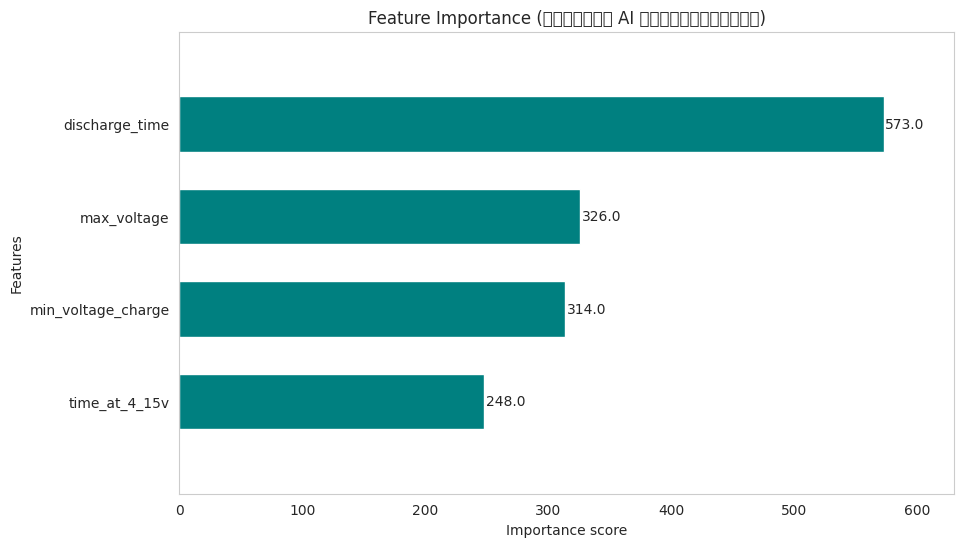

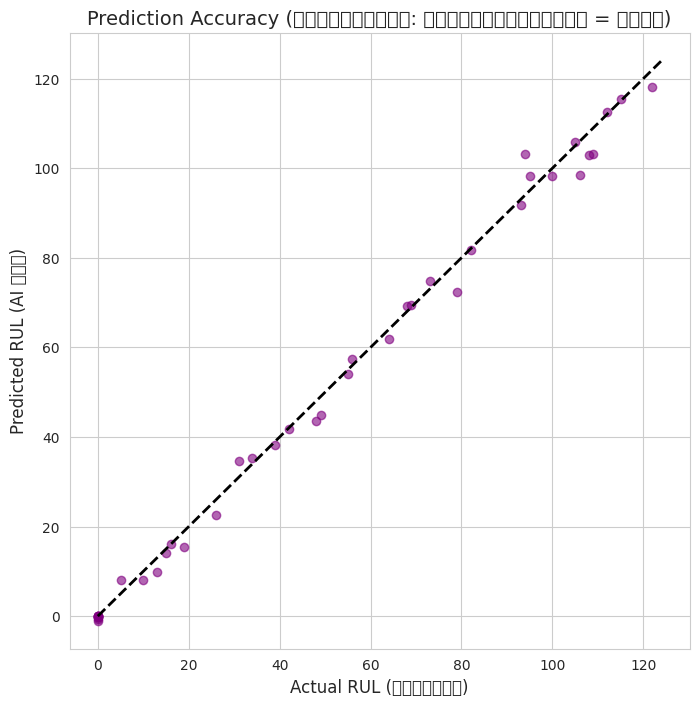

✅ กราฟพร้อมนำเสนอครับ!


In [6]:
print("📊 กำลังสร้างกราฟวิเคราะห์ผล XGBoost...")

# 1. Feature Importance
plt.figure(figsize=(10, 5))
xgb.plot_importance(xgb_model, height=0.6, title='Feature Importance (สิ่งที่ AI ให้ความสำคัญ)', color='teal', grid=False)
plt.show()

# 2. Prediction Error (จริง vs ทาย)
preds = xgb_model.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, preds, alpha=0.6, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # เส้นอุดมคติ
plt.title('Prediction Accuracy (ความแม่นยำ: จุดเกาะเส้นประ = แม่น)', fontsize=14)
plt.xlabel('Actual RUL (ค่าจริง)', fontsize=12)
plt.ylabel('Predicted RUL (AI ทาย)', fontsize=12)
plt.show()

print("✅ กราฟพร้อมนำเสนอครับ!")